In [1]:
from imp import reload
import os
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load a test image
test_img_file = './test_images/test1.jpg'
test_img_rgb = cv2.cvtColor(cv2.imread(test_img_file), cv2.COLOR_BGR2RGB)

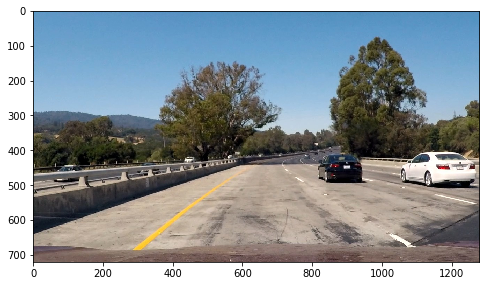

In [3]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(test_img_rgb)
plt.show()

In [4]:
from sklearn.externals import joblib

scaler = joblib.load('./classifiers/standard_scaler.pkl')
clf = joblib.load('./classifiers/linear_svm.pkl')

In [5]:
from utils import vehicle_detection; reload(vehicle_detection)

bbox_list = vehicle_detection.find_cars(
    test_img_rgb, y_start=250,  y_stop=700,
    classifier=clf, X_scaler=scaler)

In [6]:
from utils import vehicle_detection; reload(vehicle_detection)

img_drawn = vehicle_detection.draw_boxes(test_img_rgb, bbox_list)

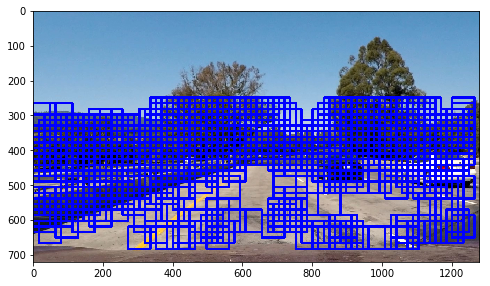

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.imshow(img_drawn)
plt.savefig(os.path.join('output_images', 'window_search.jpg'))
plt.show()

In [8]:
# heatmap
from utils import vehicle_detection; reload(vehicle_detection)

heatmap = np.zeros_like(test_img_rgb[:, :, 0]).astype(np.float)
heatmap = vehicle_detection.add_heat(heatmap, bbox_list)
heatmap = vehicle_detection.apply_threshold(heatmap, 1)

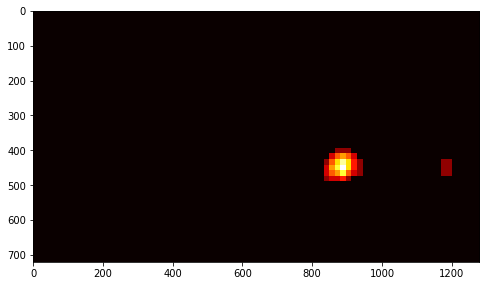

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.imshow(np.clip(heatmap, 0, 255), cmap='hot')
plt.show()

In [10]:
# labeled bbox
from scipy.ndimage.measurements import label

from utils import vehicle_detection; reload(vehicle_detection)

labels = label(heatmap)
img_detected = vehicle_detection.draw_labeled_bboxes(test_img_rgb, labels)

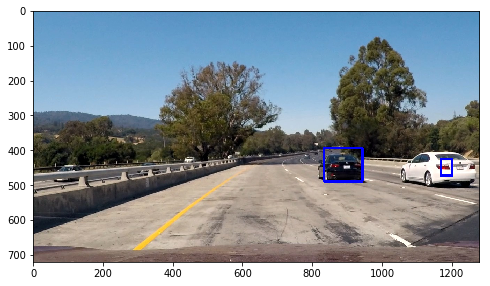

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(img_detected)
plt.show()

### pipeline test

In [12]:
from scipy.ndimage.measurements import label

from utils import vehicle_detection


def pipeline(img):
    # Find bboxes
    bbox_list = vehicle_detection.find_cars(
        img, y_start=250,  y_stop=700,
        classifier=clf, X_scaler=scaler)
    # Heatmap
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap = vehicle_detection.add_heat(heatmap, bbox_list)
    heatmap = vehicle_detection.apply_threshold(heatmap, 1)
    # Labeled bbox
    labels = label(heatmap)
    img_detected = vehicle_detection.draw_labeled_bboxes(img, labels)

    return img_detected

In [13]:
img_files = glob.glob(os.path.join('test_images', '*.jpg'))
imgs = []
for img_file in img_files:
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    imgs.append(img)

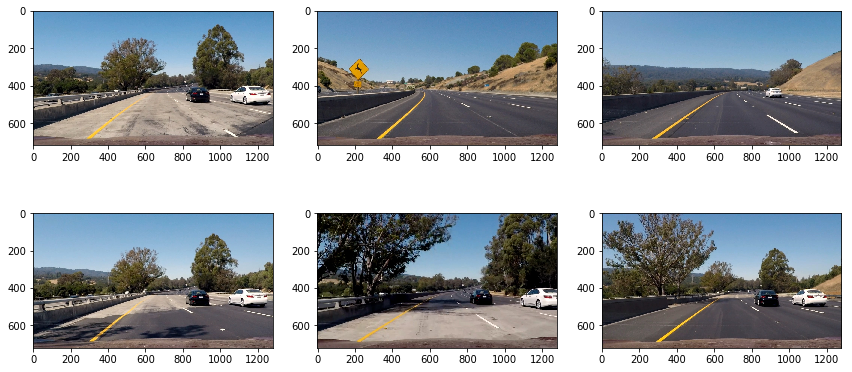

In [14]:
# test images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

axes[0][0].imshow(imgs[0])
axes[0][1].imshow(imgs[1])
axes[0][2].imshow(imgs[2])
axes[1][0].imshow(imgs[3])
axes[1][1].imshow(imgs[4])
axes[1][2].imshow(imgs[5])
plt.tight_layout()
plt.show()

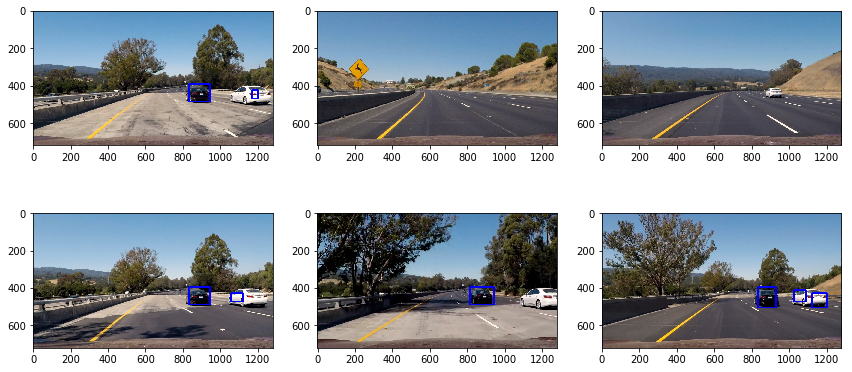

In [16]:
# Cars detected
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes[0][0].imshow(pipeline(imgs[0]))
axes[0][1].imshow(pipeline(imgs[1]))
axes[0][2].imshow(pipeline(imgs[2]))
axes[1][0].imshow(pipeline(imgs[3]))
axes[1][1].imshow(pipeline(imgs[4]))
axes[1][2].imshow(pipeline(imgs[5]))
plt.tight_layout()
plt.savefig(os.path.join('output_images', 'window_search_2_test1to6.jpg'))
plt.show()